<a href="https://colab.research.google.com/github/ilinashah177/Coursework-Website/blob/main/Another_copy_of_Regression_Investments_and_Energy_Capacity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Draw graphs "inline" in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from math import sqrt
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from scipy.stats import sem
import statistics
import seaborn as sns
from IPython.display import display, Math, Latex, display_latex
import plotly.express as px
import pylab
import pandas as pd
import numpy as np
#Make the plots (graphs) a little wider by default
pylab.rcParams['figure.figsize'] = (10., 8.)
sns.set(font_scale=1.5)
sns.set_style("white")

In [ ]:
from google.colab import files

# Upload the file
uploaded = files.upload()

Saving Data Group14.xlsx to Data Group14.xlsx


In [ ]:
import pandas as pd

#Name of uploaded file
file_name = 'Data Group14.xlsx'

#Read data from the two sheets
sheet1_df = pd.read_excel(file_name, sheet_name='BRI investments')
sheet2_df = pd.read_excel(file_name, sheet_name='TECA')

#Print data from both sheets
print("Data from Sheet1:")
print(sheet1_df.head())

print("Data from Sheet2:")
print(sheet2_df.head())

Data from Sheet1:
   Year  BRI Investments in Energy Sector (USD millions)
0  2015                                           520.40
1  2016                                           893.25
2  2017                                          2296.00
3  2018                                          2062.00
4  2019                                          2907.00
Data from Sheet2:
   Year  Total Energy Capacity Added from Completed CPEC Projects (MW)
0  2015                                                400            
1  2016                                                650            
2  2017                                               1469            
3  2018                                               1420            
4  2019                                               1980            


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

#Merge the two DataFrames based on the 'Year' column
data = pd.merge(sheet1_df, sheet2_df, on='Year')
data.head()

,Year,BRI Investments in Energy Sector (USD millions),Total Energy Capacity Added from Completed CPEC Projects (MW)
0,2015,520.40,400
1,2016,893.25,650
2,2017,2296.00,1469
3,2018,2062.00,1420
4,2019,2907.00,1980


In [ ]:
#Generate summary statistics, and round everything to 2 decimal places
summary=data.describe().round(2)
summary

,Year,BRI Investments in Energy Sector (USD millions),Total Energy Capacity Added from Completed CPEC Projects (MW)
count,10.00,10.00,10.00
mean,2019.50,1883.46,1129.00
std,3.03,770.19,475.62
min,2015.00,520.40,400.00
25%,2017.25,1480.00,743.25
50%,2019.50,2031.00,1210.00
75%,2021.75,2374.00,1410.00
max,2024.00,2907.00,1980.00


In [ ]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

#Define outliers as data points outside of Q1 - 1.5*IQR or Q3 + 1.5*IQR
outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)

#Remove outliers
data_cleaned = data[~outliers]
print(data_cleaned)

   Year  BRI Investments in Energy Sector (USD millions)  \
0  2015                                           520.40   
1  2016                                           893.25   
2  2017                                          2296.00   
3  2018                                          2062.00   
4  2019                                          2907.00   
5  2020                                          1600.00   
6  2021                                          2400.00   
7  2022                                          2716.00   
8  2023                                          1440.00   
9  2024                                          2000.00   

   Total Energy Capacity Added from Completed CPEC Projects (MW)  
0                                                400              
1                                                650              
2                                               1469              
3                                               1420              
4   

Text(69.75, 0.5, 'Total Energy Capacity Added from Completed CPEC Projects (MW)')

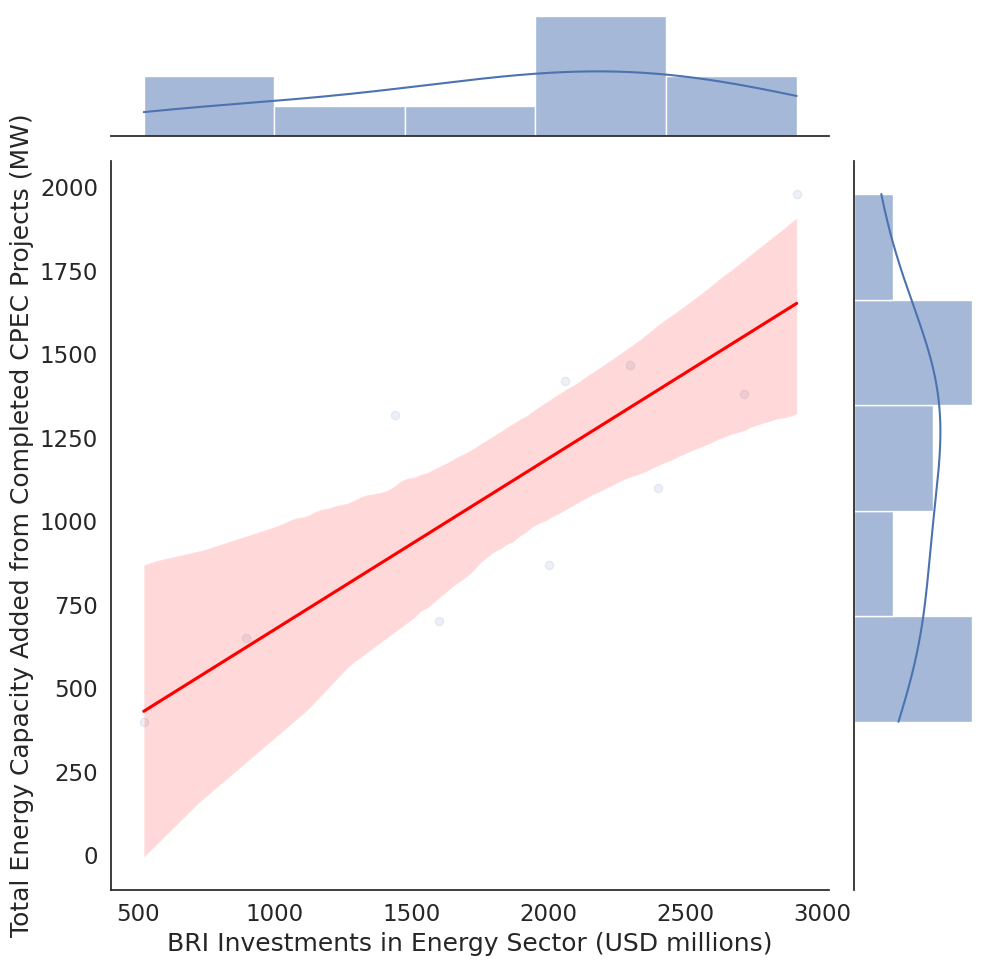

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

#Plot scatterplot and two histograms
sns.jointplot(data=data_cleaned,
              x='BRI Investments in Energy Sector (USD millions)',
              y='Total Energy Capacity Added from Completed CPEC Projects (MW)',
              kind="reg",
              scatter_kws=dict(alpha=0.1),
              line_kws=dict(color='red'),
              height=10)

#Add labels to the axes
plt.xlabel('BRI Investments in Energy Sector (USD millions)')
plt.ylabel('Total Energy Capacity Added from Completed CPEC Projects (MW)')

Text(0.5, 1.0, 'Correlation Matrix')

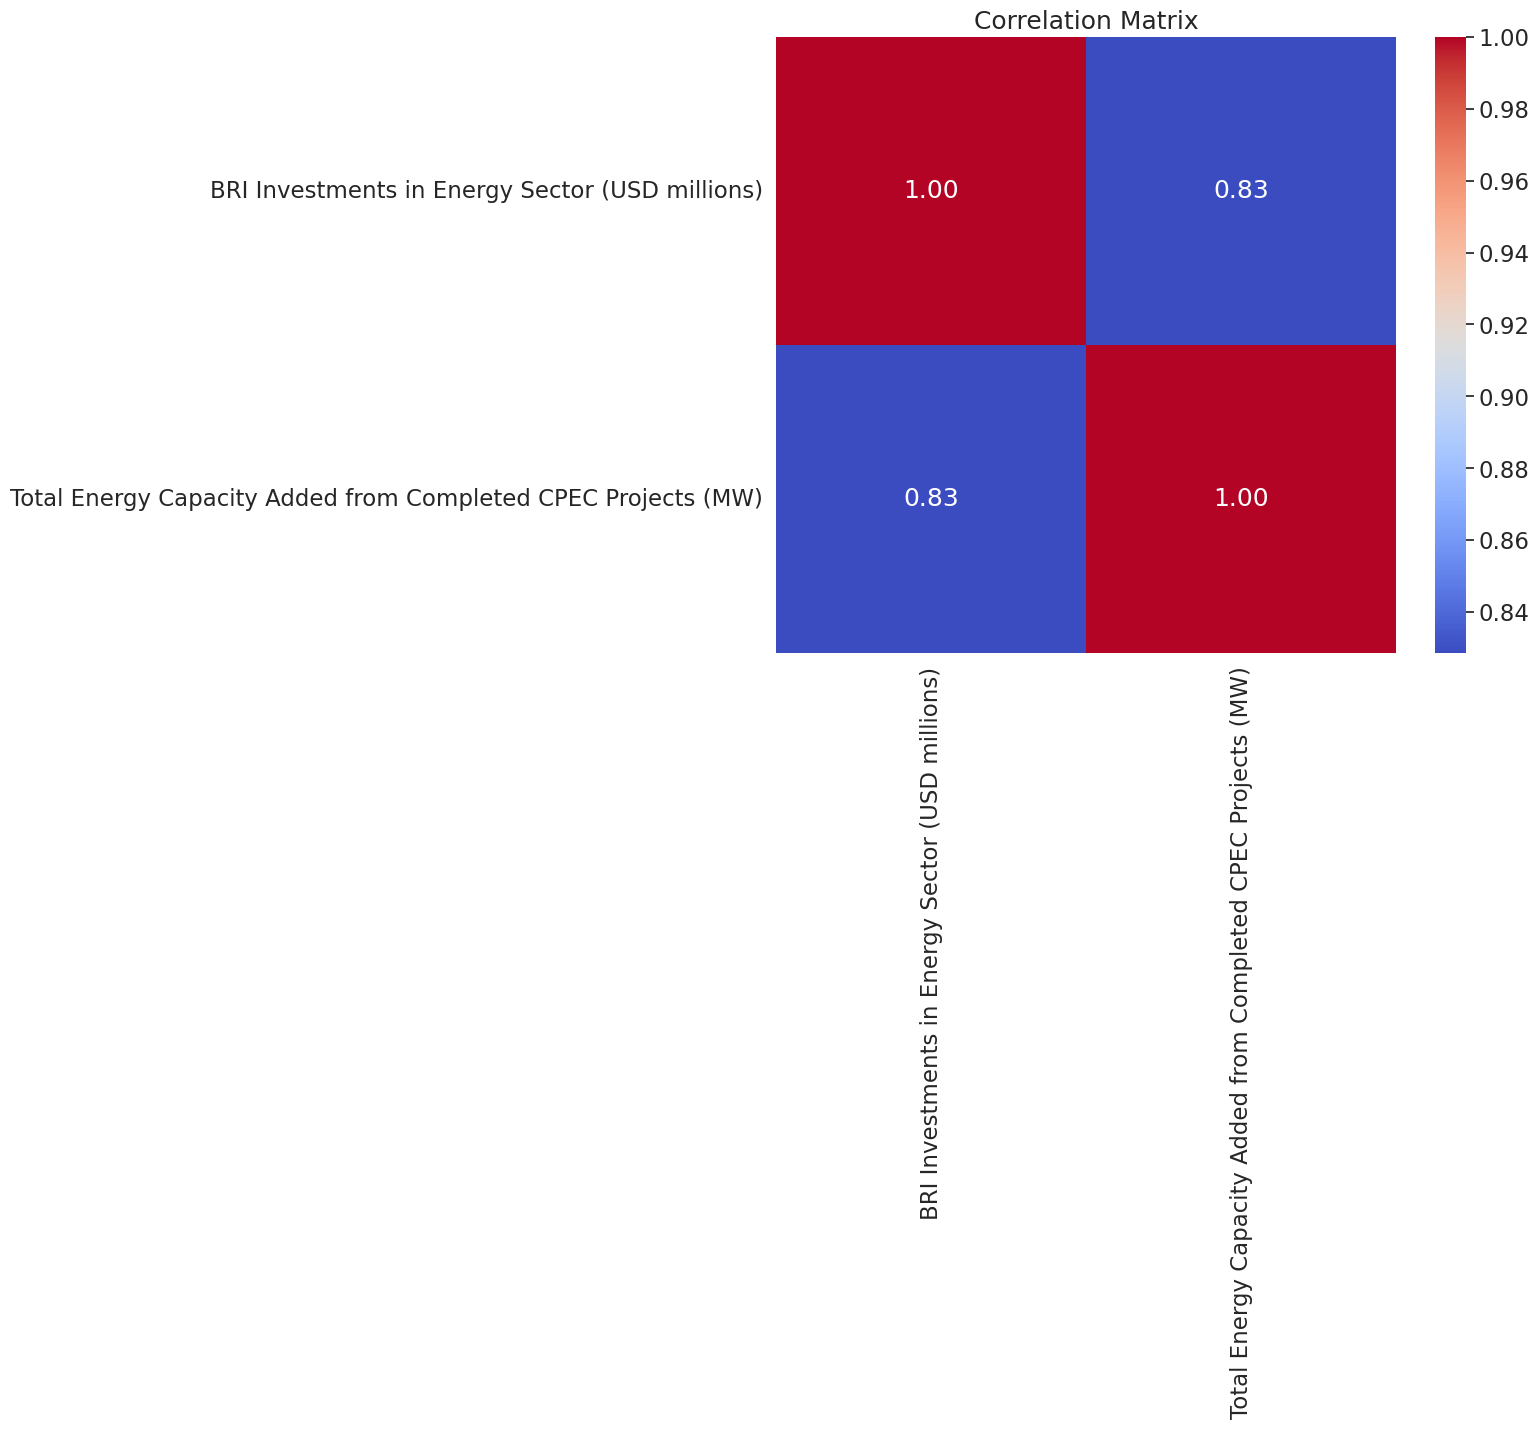

In [ ]:
sns.heatmap(data_cleaned[['BRI Investments in Energy Sector (USD millions)','Total Energy Capacity Added from Completed CPEC Projects (MW)']].corr(), #Plot a correlation matrix
            annot=True, #Show the correlation values on the plot
            fmt=".2f", #Set the format of the correlation values to be two decimal places
            cmap='coolwarm') #Set the color palette to be coolwarm (blue for negative correlations, red for positive correlations)

plt.title('Correlation Matrix') #Add a title

In [ ]:
#Calculating VIF
#This function is amended from: https://stackoverflow.com/a/51329496/4667568

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(data_cleaned, list_var_not_to_remove=None, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param list_var_not_to_remove: the list of variables that should not be removed even though it has a high VIF. For example, dummy (or indicator) variables represent a categorical variable with three or more categories.
    :param thresh: the max VIF value before the feature is removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    # Initialize df with data_cleaned to ensure it's defined
    df = data_cleaned.copy()

    while True:
        #Adding a constant item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i)
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        #Drop the const as const should not be removed
        vif_df = vif_df.drop('const')

        #Drop the variables that should not be removed
        if list_var_not_to_remove is not None:
            vif_df = vif_df.drop(list_var_not_to_remove)

        print('Max VIF:', vif_df.VIF.max())

        #If the largest VIF is above the thresh, remove a variable with the largest VIF
        if vif_df.VIF.max() > thresh:
            #If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            #No VIF is above threshold, exit the loop
            break

    return df

In [ ]:
vars=['BRI Investments in Energy Sector (USD millions)','Total Energy Capacity Added from Completed CPEC Projects (MW)']

vif = drop_column_using_vif_(data_cleaned[vars], thresh=5)
print("The columns remaining after VIF selection are:")
print(vif.columns)

Max VIF: 3.1899672140876696
The columns remaining after VIF selection are:
Index(['BRI Investments in Energy Sector (USD millions)', 'Total Energy Capacity Added from Completed CPEC Projects (MW)'], dtype='object')


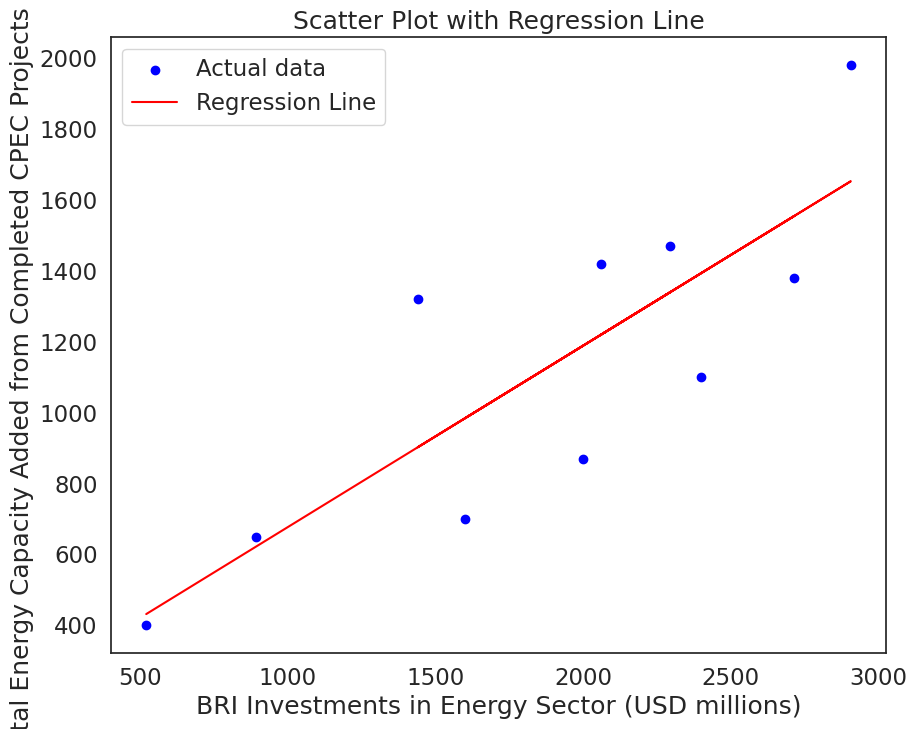

In [ ]:
#Select features (X) and target (y)
X = data_cleaned[['BRI Investments in Energy Sector (USD millions)']]
y = data_cleaned['Total Energy Capacity Added from Completed CPEC Projects (MW)']

#Perform Linear Regression
model = LinearRegression()
model.fit(X, y)

#Predict values using the regression model
y_pred = model.predict(X)

#Create the scatter plot
plt.scatter(X, y, color='blue', label='Actual data')

#Plot the regression line
plt.plot(X, y_pred, color='red', label='Regression Line')

#Add labels and title
plt.xlabel('BRI Investments in Energy Sector (USD millions)')
plt.ylabel('Total Energy Capacity Added from Completed CPEC Projects (MW)')
plt.title('Scatter Plot with Regression Line')
plt.legend()

#Show the plot
plt.show()

In [ ]:
from statsmodels.formula.api import ols
from statsmodels.iolib.summary2 import summary_col

In [ ]:
#Fit the model
model=ols('Q("Total Energy Capacity Added from Completed CPEC Projects (MW)") ~ Q("BRI Investments in Energy Sector (USD millions)")', data=data_cleaned).fit()
print(model.summary())

                                                    OLS Regression Results                                                    
Dep. Variable:     Q("Total Energy Capacity Added from Completed CPEC Projects (MW)")   R-squared:                       0.687
Model:                                                                            OLS   Adj. R-squared:                  0.647
Method:                                                                 Least Squares   F-statistic:                     17.52
Date:                                                                Fri, 03 Jan 2025   Prob (F-statistic):            0.00306
Time:                                                                        09:40:17   Log-Likelihood:                -69.509
No. Observations:                                                                  10   AIC:                             143.0
Df Residuals:                                                                       8   BIC:                   

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
print('The t-statistic for this regression model is 4.186.')
print('The p-value for this regression model is 0.003.')
print('As the p-value is less than 0.05, the null hypothesis is rejected, and there is a statistically significant relationship between the two variables.')

The t-statistic for this regression model is 4.186.
The p-value for this regression model is 0.003.
As the p-value is less than 0.05, the null hypothesis is rejected, and there is a statistically significant relationship between the two variables.


In [1]:
#Draw graphs "inline" in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from math import sqrt
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from scipy.stats import sem
import statistics
import seaborn as sns
from IPython.display import display, Math, Latex, display_latex
import plotly.express as px
import pylab
import pandas as pd
import numpy as np
#Make the plots (graphs) a little wider by default
pylab.rcParams['figure.figsize'] = (10., 8.)
sns.set(font_scale=1.5)
sns.set_style("white")

from google.colab import files

# Upload the file
uploaded = files.upload()

Saving Data Group14.xlsx to Data Group14.xlsx


In [2]:
import pandas as pd

#Name of uploaded file
file_name = 'Data Group14.xlsx'

#Read data from the two sheets
sheet1_df2 = pd.read_excel(file_name, sheet_name='BRI investments')
sheet2_df2 = pd.read_excel(file_name, sheet_name='Energy consumption')

def remove_unnamed_columns(df):
  """Removes columns with names starting with 'Unnamed'."""
  unnamed_cols = [col for col in df.columns if 'Unnamed' in col]
  return df.drop(columns=unnamed_cols)

sheet1_df2_cleaned = remove_unnamed_columns(sheet1_df2)
sheet2_df2_cleaned = remove_unnamed_columns(sheet2_df2)

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

#Merge the two DataFrames based on the 'Year' column
data2 = pd.merge(sheet1_df2_cleaned, sheet2_df2_cleaned, on='Year')
data2.head()

,Year,BRI Investments in Energy Sector (USD millions),Total electricity consumption (GWh)
0,2015,520.40,85818
1,2016,893.25,90431
2,2017,2296.00,95529
3,2018,2062.00,106928
4,2019,2907.00,109461


In [4]:
summary2=data2.describe().round(2)  # generate summary statistics, and round everything to 2 decimal degrees
summary2

,Year,BRI Investments in Energy Sector (USD millions),Total electricity consumption (GWh)
count,10.00,10.00,10.00
mean,2019.50,1883.46,104968.10
std,3.03,770.19,10559.00
min,2015.00,520.40,85818.00
25%,2017.25,1480.00,98378.75
50%,2019.50,2031.00,108916.00
75%,2021.75,2374.00,111138.25
max,2024.00,2907.00,116816.00


In [7]:
Q1_2 = data2.quantile(0.25)
Q3_2 = data2.quantile(0.75)
IQR_2 = Q3_2 - Q1_2

#Define outliers as data points outside of Q1 - 1.5*IQR or Q3 + 1.5*IQR
outliers2 = ((data2 < (Q1_2 - 1.5 * IQR_2)) | (data2 > (Q3_2 + 1.5 * IQR_2))).any(axis=1)

#Remove outliers
data_cleaned2 = data2[~outliers2]
print(data_cleaned2)

   Year  BRI Investments in Energy Sector (USD millions)  \
0  2015                                           520.40   
1  2016                                           893.25   
2  2017                                          2296.00   
3  2018                                          2062.00   
4  2019                                          2907.00   
5  2020                                          1600.00   
6  2021                                          2400.00   
7  2022                                          2716.00   
8  2023                                          1440.00   
9  2024                                          2000.00   

   Total electricity consumption (GWh)  
0                                85818  
1                                90431  
2                                95529  
3                               106928  
4                               109461  
5                               108371  
6                               116816  
7          

Text(69.75, 0.5, 'Total electricity consumption (GWh)')

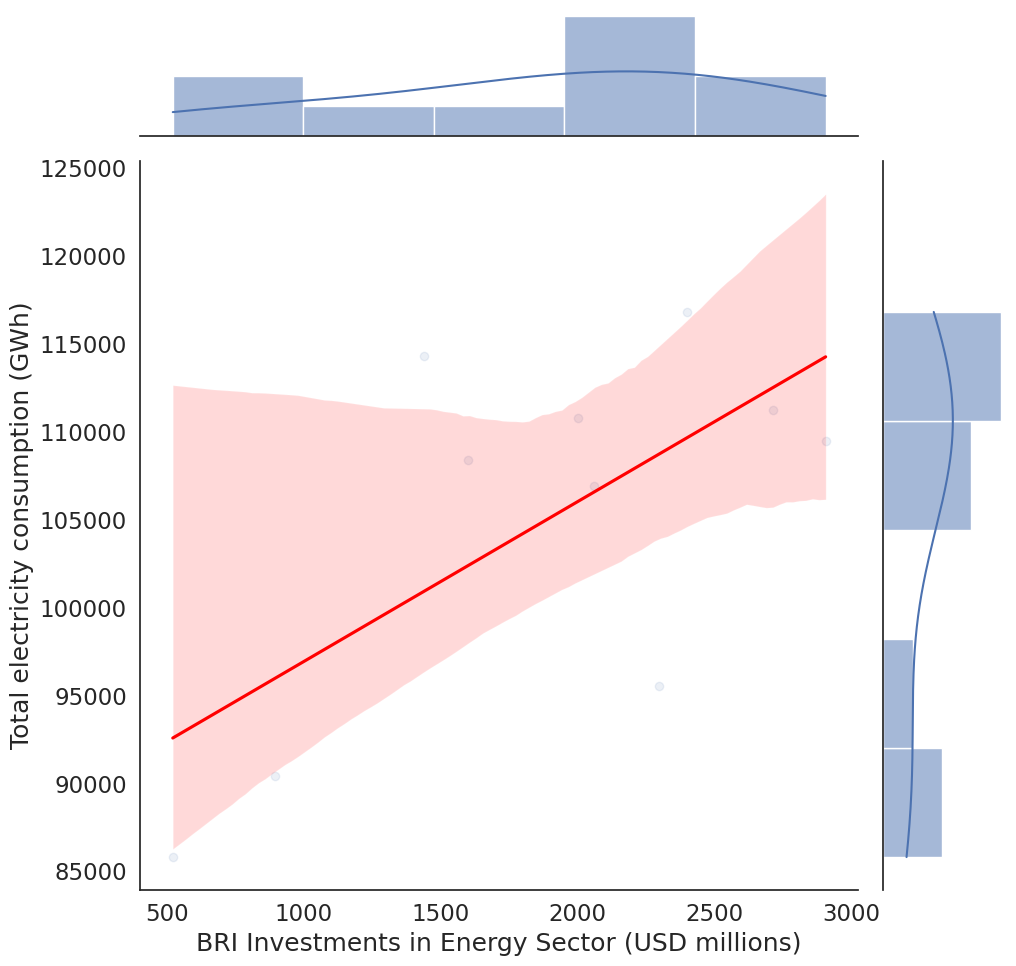

In [8]:
sns.jointplot(data=data2, # plot a scatterplot with a regression line and two histograms
                x='BRI Investments in Energy Sector (USD millions)', # set the x axis to be the years of schooling
                y='Total electricity consumption (GWh)', # set the y axis to be the hourly wage
                kind="reg",  # set the kind of plot to be a regression plot
                scatter_kws=dict(alpha=0.1), # set the transparency of the points to be 0.1 (10%)
                line_kws=dict(color='red'), # set the color of the regression line to red
                height=10) # set the height of the plot to be 10 inches

plt.xlabel('BRI Investments in Energy Sector (USD millions)') # add a label to the x axis
plt.ylabel('Total electricity consumption (GWh)') # add a label to the y axis

Text(0.5, 1.0, 'Correlation Matrix')

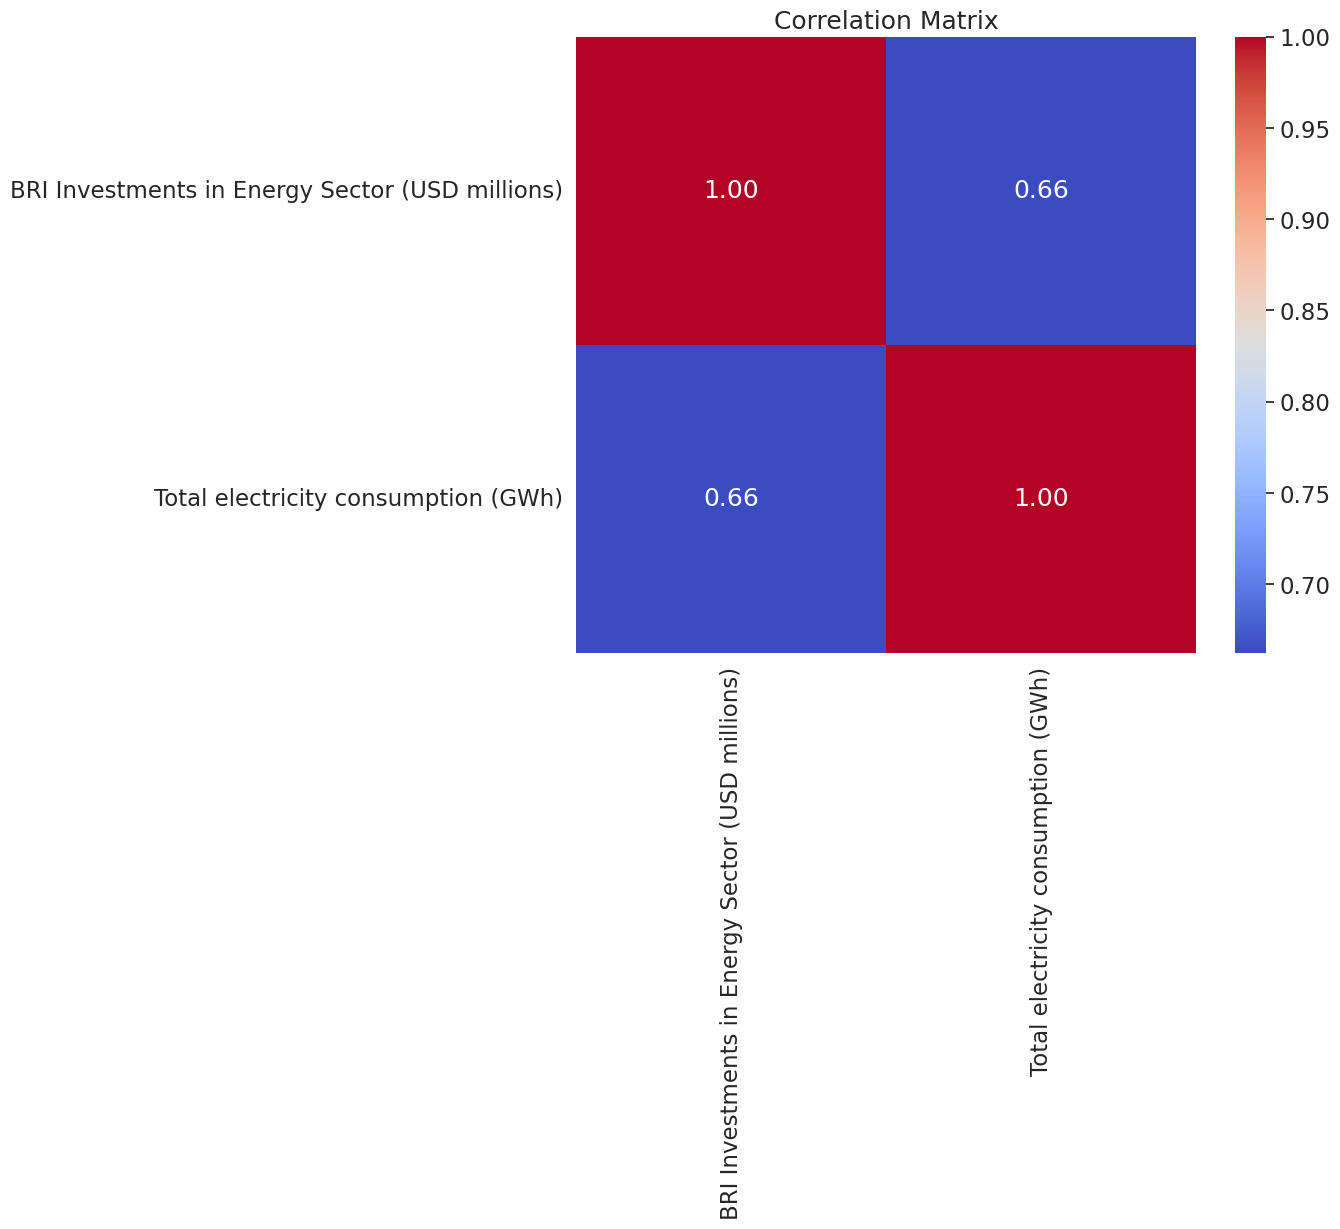

In [9]:
sns.heatmap(data2[['BRI Investments in Energy Sector (USD millions)','Total electricity consumption (GWh)']].corr(), # plot a correlation matrix
            annot=True, # show the correlation values on the plot
            fmt=".2f", # set the format of the correlation values to be two decimal places
            cmap='coolwarm') # set the color palette to be coolwarm (blue for negative correlations, red for positive correlations)

plt.title('Correlation Matrix') # add a title

In [10]:
#Calculating VIF
#This function is amended from: https://stackoverflow.com/a/51329496/4667568

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(data2, list_var_not_to_remove=None, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param list_var_not_to_remove: the list of variables that should not be removed even though it has a high VIF. For example, dummy (or indicator) variables represent a categorical variable with three or more categories.
    :param thresh: the max VIF value before the feature is removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    # Initialize df with data_cleaned to ensure it's defined
    df2 = data2.copy()

    while True:
        #Adding a constant item to the data
        df_with_const2 = add_constant(df2)

        vif_df2 = pd.Series([variance_inflation_factor(df_with_const2.values, i)
               for i in range(df_with_const2.shape[1])], name= "VIF",
              index=df_with_const2.columns).to_frame()

        #Drop the const as const should not be removed
        vif_df2 = vif_df2.drop('const')

        #Drop the variables that should not be removed
        if list_var_not_to_remove is not None:
            vif_df2 = vif_df2.drop(list_var_not_to_remove)

        print('Max VIF:', vif_df2.VIF.max())

        #If the largest VIF is above the thresh, remove a variable with the largest VIF
        if vif_df2.VIF.max() > thresh:
            #If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df2.index[vif_df2.VIF == vif_df2.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df2 = df2.drop(columns = index_to_drop)
        else:
            #No VIF is above threshold, exit the loop
            break

    return df2

In [11]:
vars2=['BRI Investments in Energy Sector (USD millions)','Total electricity consumption (GWh)']

vif2 = drop_column_using_vif_(data2[vars2], thresh=5)
print("The columns remaining after VIF selection are:")
print(vif2.columns)

Max VIF: 1.7819992380161396
The columns remaining after VIF selection are:
Index(['BRI Investments in Energy Sector (USD millions)', 'Total electricity consumption (GWh)'], dtype='object')


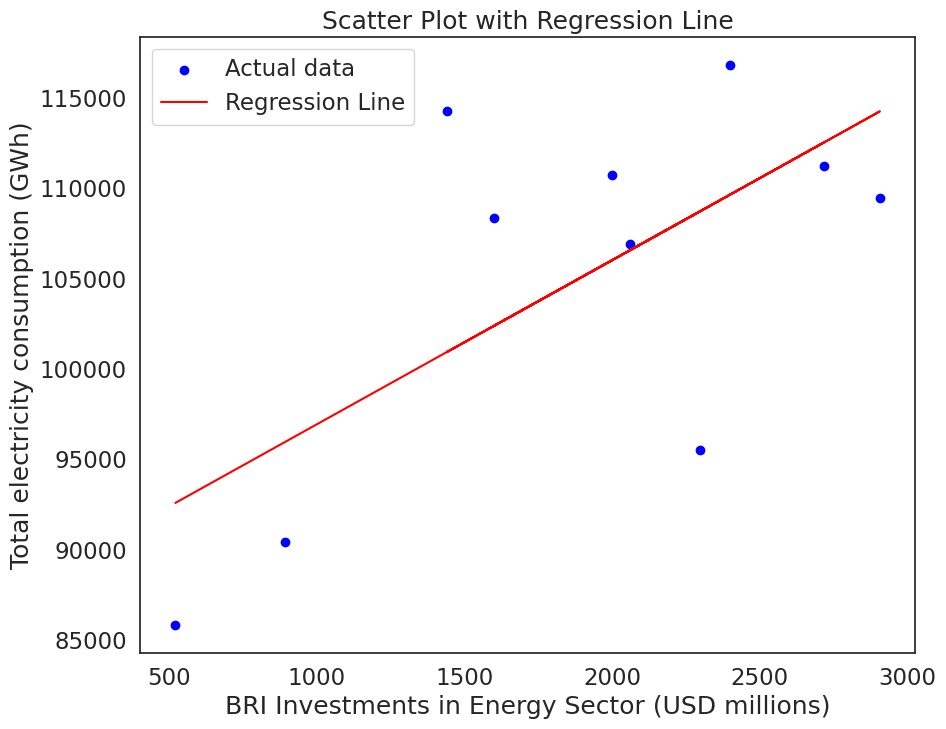

In [12]:
#Select features (X) and target (y)
X = data2[['BRI Investments in Energy Sector (USD millions)']]
y = data2['Total electricity consumption (GWh)']

#Perform Linear Regression
model2 = LinearRegression()
model2.fit(X, y)

#Predict values using the regression model
y_pred = model2.predict(X)

#Create the scatter plot
plt.scatter(X, y, color='blue', label='Actual data')

#Plot the regression line
plt.plot(X, y_pred, color='red', label='Regression Line')

#Add labels and title
plt.xlabel('BRI Investments in Energy Sector (USD millions)')
plt.ylabel('Total electricity consumption (GWh)')
plt.title('Scatter Plot with Regression Line')
plt.legend()

#Show the plot
plt.show()

In [13]:
from statsmodels.formula.api import ols
from statsmodels.iolib.summary2 import summary_col

In [14]:
model2_sm = ols('Q("Total electricity consumption (GWh)") ~ Q("BRI Investments in Energy Sector (USD millions)")', data=data2).fit()
print(model2_sm.summary())

                                       OLS Regression Results                                       
Dep. Variable:     Q("Total electricity consumption (GWh)")   R-squared:                       0.439
Model:                                                  OLS   Adj. R-squared:                  0.369
Method:                                       Least Squares   F-statistic:                     6.256
Date:                                      Fri, 03 Jan 2025   Prob (F-statistic):             0.0369
Time:                                              10:03:37   Log-Likelihood:                -103.42
No. Observations:                                        10   AIC:                             210.8
Df Residuals:                                             8   BIC:                             211.4
Df Model:                                                 1                                         
Covariance Type:                                  nonrobust                                

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  res = hypotest_fun_out(*samples, **kwds)


In [15]:
print('The t-statistic for this regression model is 2.501.')
print('The p-value for this regression model is 0.037.')
print('As the p-value is less than 0.05, the null hypothesis is rejected, and there is a statistically significant relationship between the two variables.')

The t-statistic for this regression model is 2.501.
The p-value for this regression model is 0.037.
As the p-value is less than 0.05, the null hypothesis is rejected, and there is a statistically significant relationship between the two variables.
